# 자연어처리 과제 2 (5주차)
* 과제는 해당 .ipynb 파일에 코드 작성
    * 코드는 google colab의 gpu를 사용하는 런타임 환경에서 모두실행을 통해 한번에 실행 되어야함
    * 생성형 AI (ChatGPT, Copilot, Claude, ...) 등 사용 가능
        * 단, 사용시 사용한 방법, 입력, 출력을 캡처해 보고서에 기입
* Word를 통해 자유형식으로 보고서를 작성
    * 보고서의 양식은 자유
    * 보고서의 제출은 .pdf 형식으로 제출해야하며, 파일명은 "학번_이름_HW_??.pdf"로 제출 할 것
    * 보고서에 코드를 그대로 복붙 하지 말 것 (캡처 도구를 활용, 환경 설치 자료 참고)
* .ipynb와 .pdf 파일을 el을 통해 제출
    * 예시 : "2232036006_임상훈_HW_01.ipynb"와 "2232036006_임상훈_HW_01.pdf"를 제출

## 1. IMDB 데이터 처리 (20점)

* Stanford 대학에서 제공하는 IMDB 영화 리뷰 데이터(https://ai.stanford.edu/~amaas/data/sentiment/)를 다운 받아 학습, 테스트 데이터를 구성하시오

    * 데이터는 영어 텍스트 데이터로 긍정/부정의 Binary classification 데이터셋임
    * 데이터셋의 압축을 해제했을 떄의 각 디렉토리의 용도는 다음과 같음
        * train/pos : 긍정 label의 학습 데이터
        * train/neg : 부정 label의 학습 데이터
        * test/pos : 긍정 label의 테스트 데이터
        * test/neg : 부정 label의 테스트 데이터
    * 지금껏 배운 다양한 기법을 적용해 tokenizing, nomalizing 등을 진행한 후 vocab을 구축하여야함

**GRADING**
* 데이터셋 전처리를 통해 vocab 구축 (+20)

In [ ]:
!tar -xzf /content/aclImdb_v1.tar.gz

In [25]:
import torch
import random
import numpy as np

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

### 1.1 Load Dataset

In [2]:
from pathlib import Path

raw_data_dir = './aclImdb'
data_dir = Path(raw_data_dir)

train_datas = []
test_datas = []

for sentiment in ["pos", "neg"]:
    samples = list(data_dir.glob(f"train/{sentiment}/*.txt"))
    train_datas.extend(samples)

for sentiment in ["pos", "neg"]:
    samples = list(data_dir.glob(f"test/{sentiment}/*.txt"))
    test_datas.extend(samples)

train_file = open("train.txt", "w", encoding="utf-8")
test_file = open("test.txt", "w", encoding="utf-8")

for file, datas in [(train_file, train_datas), (test_file, test_datas)]:
    file.write("id\ttext\tlabel\n")
    for data in datas:
        lines = [line.strip().replace("\t", " ") for line in data.open().readlines()]
        text = " ".join(lines)
        id = data.name[:-4]
        label = 1 if "pos" in data.parts else 0
        file.write(f"{id}\t{text}\t{label}\n")
    
train_file.close()
test_file.close()

In [2]:
with open("train.txt", "r", encoding="utf-8") as file:
    contents = file.read()
    lines = contents.split("\n")[1:]
    train_data = [line.split("\t") for line in lines if len(line) > 0]

with open("test.txt", "r", encoding="utf-8") as file:
    contents = file.read()
    lines = contents.split("\n")[1:]
    test_data = [line.split("\t") for line in lines if len(line) > 0]

### 1.2 Vocab 구축

In [3]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/dev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import re
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

tokenized_train_dataset = []
tokenized_test_dataset = []

for data in tqdm(train_data):
    text = data[1].lower().replace('<br />', '')  # Remove <br /> tags and lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    labels = data[2]
    tokenized_train_dataset.append((tokens, labels))

for data in tqdm(test_data):
    text = data[1].lower().replace('<br />', '')  # Remove <br /> tags and lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    labels = data[2]
    tokenized_test_dataset.append((tokens, labels))

100%|██████████| 25000/25000 [00:24<00:00, 1001.81it/s]


In [6]:
from collections import Counter

token_counter = Counter()

for tokens, _ in tokenized_train_dataset:
    token_counter.update(tokens)

min_count = 2
vocab = {"[PAD]":0, "[UNK]":1}
vocab_idx = 2

for token, count in token_counter.items():
    if count > min_count:
        vocab[token] = vocab_idx
        vocab_idx += 1

In [7]:
print(token_counter.most_common(10))
print(token_counter.most_common()[-10:])

[('movi', 49582), ('film', 46295), ('one', 26314), ('like', 22059), ('time', 15079), ('good', 14711), ('make', 14498), ('get', 14022), ('charact', 13797), ('see', 13767)]
[('autonom', 1), ('releasedaft', 1), ('herselfther', 1), ('matteral', 1), ('gli', 1), ('occhi', 1), ('dentro', 1), ('fuzzylin', 1), ('supervan', 1), ('lasar', 1)]


In [8]:
word2vec_train_datas = []
for train_text, _ in tokenized_train_dataset:
    word2vec_train_datas.append([word for word in train_text])

In [9]:
from gensim.models import Word2Vec

SkipGram_W2V = Word2Vec(sentences = word2vec_train_datas, vector_size = 200, window = 5, min_count = 1, workers = 4, sg = 1)

In [10]:
import numpy as np

embedding_list = []

for token, idx in vocab.items():
    if token in SkipGram_W2V.wv:
        embedding_list.append(SkipGram_W2V.wv[token])
    elif token == "[PAD]":
        embedding_list.append(np.zeros(SkipGram_W2V.wv.vectors.shape[1]))
    elif token == "[UNK]":
        embedding_list.append(np.random.uniform(-1, 1, SkipGram_W2V.wv.vectors.shape[1]))
    else:
        embedding_list.append(np.random.uniform(-1, 1, SkipGram_W2V.wv.vectors.shape[1]))

embedding_lookup_matrix = np.vstack(embedding_list)

print(embedding_lookup_matrix.shape)
print(len(vocab))


(29544, 200)
29544


## 2. 데이터셋 통계 분석 (30점)
* 1에서 처리한 vocab을 통해 tokenizing 된 데이터셋의 여러 통계를 계산하시오
    * 통계의 예시
        * 학습/테스트 문서의 수
        * 학습/테스트 데이터의 평균 token 수
        * 데이터의 token histogram
        * 학습/테스트에서의 unk token의 수
        * 각 token의 빈도 그래프
        * 긍정/부정의 token 빈도 차이
        * 긍정/부정의 frequent/rare token

* 이전 실습까지 사용한 코드 및 검색을 활용하여 최소 1개의 그래프를 그려야 함

**GRADING**
* 분석한 통계의 수 (+5)

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

In [12]:
# 학습/테스트 문서의 수
print('Train Document : ', len(tokenized_train_dataset))
print('Test Document : ', len(tokenized_test_dataset))

Train Document :  25000
Test Document :  25000


In [13]:
# 학습/테스트 데이터의 평균 token 수
train_avg_tokens = sum(map(lambda x: len(x[0]), tokenized_train_dataset)) / len(tokenized_train_dataset)
test_avg_tokens = sum(map(lambda x: len(x[0]), tokenized_test_dataset)) / len(tokenized_test_dataset)

print('학습 데이터의 평균 token 수: ', train_avg_tokens)
print('테스트 데이터의 평균 token 수: ', test_avg_tokens)

학습 데이터의 평균 token 수:  121.16284
테스트 데이터의 평균 token 수:  118.39504


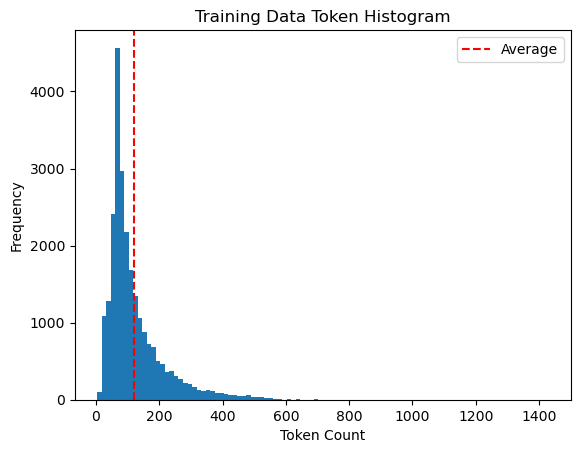

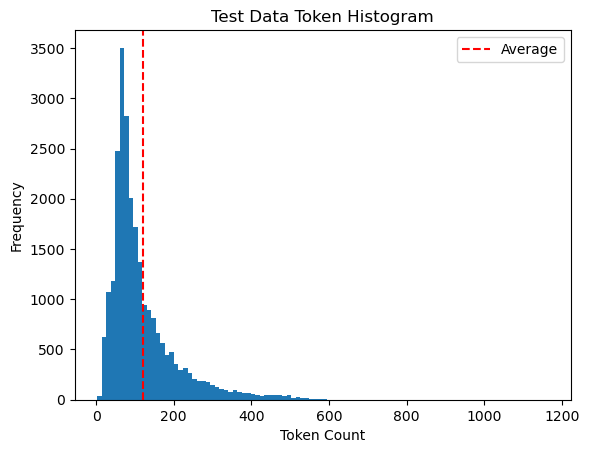

In [23]:
# 데이터의 token histogram
train_tokens = [len(tokens) for tokens, _ in tokenized_train_dataset]
test_tokens = [len(tokens) for tokens, _ in tokenized_test_dataset]

# Train
plt.hist(train_tokens, bins=100)
plt.title('Training Data Token Histogram')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.axvline(x=train_avg_tokens, color='red', linestyle='--', label='Average')
plt.legend()
plt.show()

# Test
plt.hist(test_tokens, bins=100)
plt.title('Test Data Token Histogram')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.axvline(x=train_avg_tokens, color='red', linestyle='--', label='Average')
plt.legend()
plt.show()

In [24]:
# 학습/테스트 데이터에서 UNK token의 수
UNK_token_train = sum(1 for tokens, _ in tokenized_train_dataset for token in tokens if token not in vocab)
UNK_token_test = sum(1 for tokens, _ in tokenized_test_dataset for token in tokens if token not in vocab)

print('학습 데이터에서 UNK token의 수: ', UNK_token_train)
print('테스트 데이터에서 UNK token의 수: ', UNK_token_test)

학습 데이터에서 UNK token의 수:  94143
테스트 데이터에서 UNK token의 수:  131896


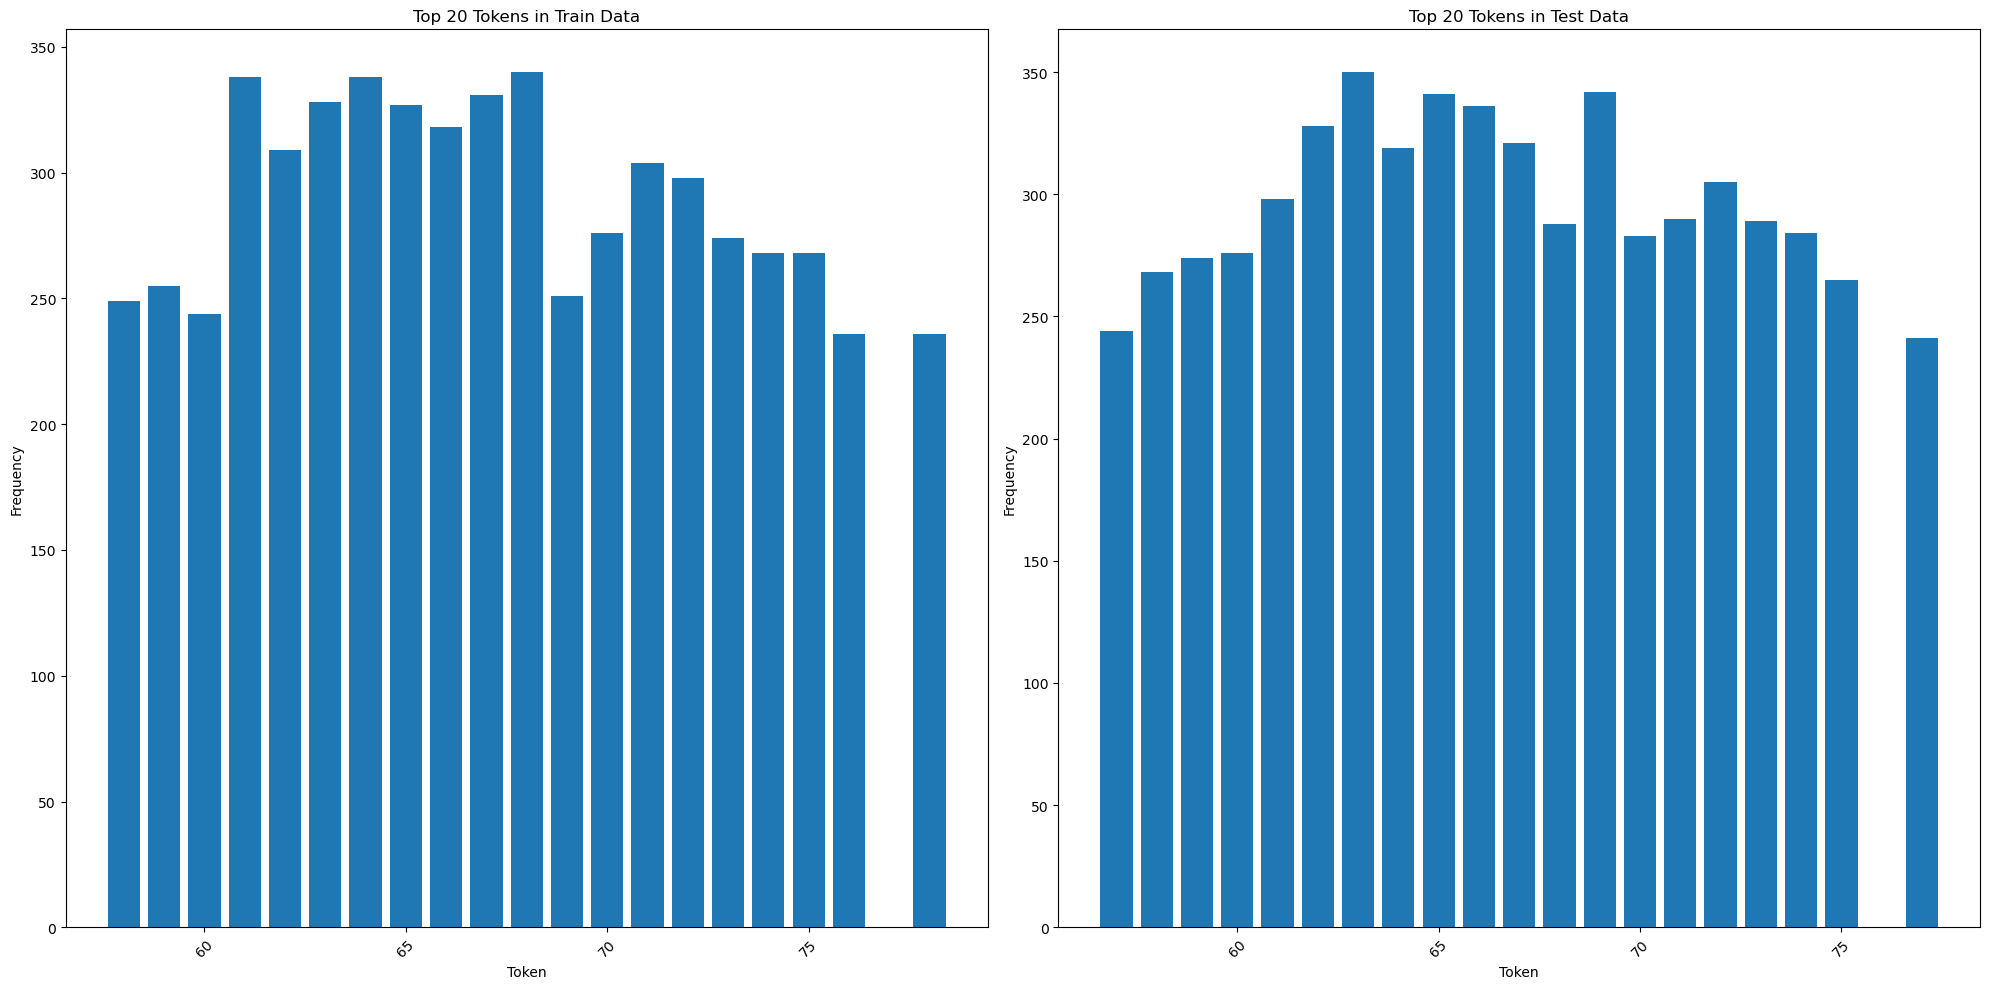

In [25]:
# 각 token의 빈도 그래프
train_token_counter = Counter(train_tokens)
test_token_counter = Counter(test_tokens)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.bar(*zip(*train_token_counter.most_common(20)))
plt.title("Top 20 Tokens in Train Data")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.bar(*zip(*test_token_counter.most_common(20)))
plt.title("Top 20 Tokens in Test Data")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

긍정 token 수:  1539472
부정 token 수:  1489599


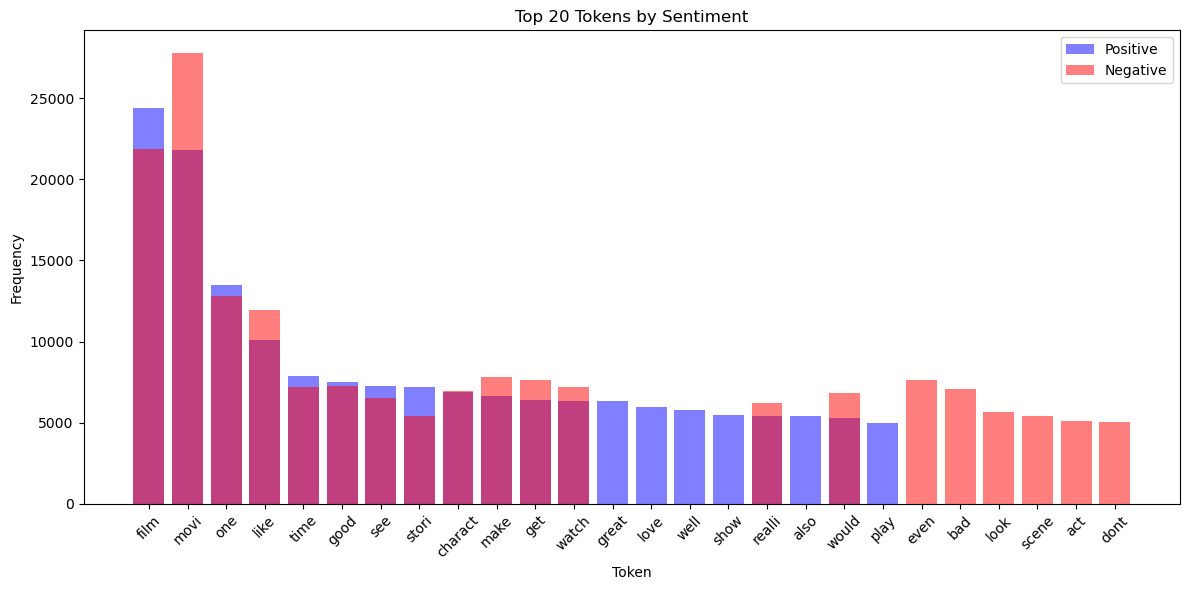

In [27]:
# 긍정/부정 token의 빈도 차이
pos_train_tokens = [token for tokens, label in tokenized_train_dataset if label == '1' for token in tokens]
neg_train_tokens = [token for tokens, label in tokenized_train_dataset if label == '0' for token in tokens]

pos_token_counter = Counter(pos_train_tokens)
neg_token_counter = Counter(neg_train_tokens)

print('긍정 token 수: ', len(pos_train_tokens))
print('부정 token 수: ', len(neg_train_tokens))

plt.figure(figsize=(12, 6))
plt.bar(*zip(*pos_token_counter.most_common(20)), color='b', alpha=0.5, label='Positive')
plt.bar(*zip(*neg_token_counter.most_common(20)), color='r', alpha=0.5, label='Negative')
plt.title("Top 20 Tokens by Sentiment")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# 긍정/부정의 frequent/rare token
pos_frequent_tokens = pos_token_counter.most_common(10)
pos_rare_tokens = pos_token_counter.most_common()[-10:]

neg_frequent_tokens = neg_token_counter.most_common(10)
neg_rare_tokens = neg_token_counter.most_common()[-10:]

print('긍정 frequent token: ', pos_frequent_tokens)
print('긍정 rare token: ', pos_rare_tokens)
print('부정 frequent token: ', neg_frequent_tokens)
print('부정 rare token: ', neg_rare_tokens)

긍정 frequent token:  [('film', 24398), ('movi', 21784), ('one', 13506), ('like', 10091), ('time', 7882), ('good', 7478), ('see', 7251), ('stori', 7187), ('charact', 6867), ('make', 6662)]
긍정 rare token:  [('cort', 1), ('garboth', 1), ('debutim', 1), ('closeupsalthough', 1), ('mathiss', 1), ('darin', 1), ('ipanema', 1), ('togetheropen', 1), ('youalan', 1), ('mauricecassavet', 1)]
부정 frequent token:  [('movi', 27798), ('film', 21897), ('one', 12808), ('like', 11968), ('make', 7836), ('even', 7603), ('get', 7602), ('good', 7233), ('time', 7197), ('watch', 7183)]
부정 rare token:  [('releasedaft', 1), ('herselfther', 1), ('auer', 1), ('matteral', 1), ('gli', 1), ('occhi', 1), ('dentro', 1), ('fuzzylin', 1), ('supervan', 1), ('lasar', 1)]


## 3. Classification 모델 구축 및 학습 (50점)
* 이론 및 실습 수업을 통해 배운 MLP, CNN, RNN을 사용하여 각자의 모델을 구축하시오
    * 모델의 크기는 ModelSummary 기준 500MB의 메모리를 초과하면 안됨
    * 모델은 최대 10 epoch 학습 할 수 있음 (적게 학습하는 것은 ok)
* 최대한 높은 성능을 기록하는 모델을 구축하여야 함
    * 학습엔 주어진 학습 데이터만을 사용하여야 함
    * 테스트 데이터를 학습에 사용하면 0점
    * 단, 테스트 데이터에 대한 통계를 보고 모델을 구축하는 것은 가능!
* 모델 구성에 있어 왜 자신이 그런 모델 구조를 설계 하였는지 설명을 하여야함

**GRADING**
* 모델 구축 및 학습 (+20)
* 모델에 대한 설명 (+10)
* 모델 성능에 따른 성적
    * 상위 0~30% :  +20
    * 상위 30~50% :  +15
    * 상위 50~70% :  +10
    * 상위 70~100% : +5

### 3.1 Padding

리뷰의 최대 길이:  1429
리뷰의 평균 길이:  121.16284


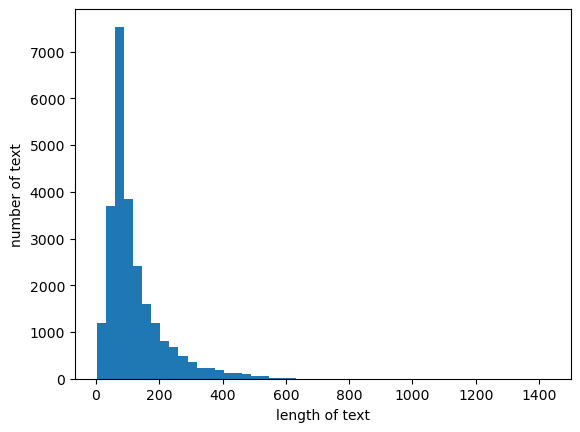

In [30]:
import matplotlib.pyplot as plt

print('리뷰의 최대 길이: ', max(len(text) for text, _ in tokenized_train_dataset))
print('리뷰의 평균 길이: ', sum(map(lambda x: len(x[0]), tokenized_train_dataset)) / len(tokenized_train_dataset))

plt.hist([len(text) for text, _ in tokenized_train_dataset], bins=50)
plt.xlabel('length of text')
plt.ylabel('number of text')
plt.show()

In [31]:
threshold = 500

count = 0
for text, _ in tokenized_train_dataset:
    if(len(text) <= threshold):
        count += 1

ratio = count / len(tokenized_train_dataset) * 100
print('tokenized_train_dataset 중 길이가 %s 이하인 텍스트의 비율: %s' %(threshold, ratio))

tokenized_train_dataset 중 길이가 500 이하인 텍스트의 비율: 99.372


### 3.2 모델 구축 및 학습

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

# define dataset class
class SentimentDataset(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = int(self.data[index][1])
        tokens = self.data[index][0]

        token_ids = [self.vocab[token] if token in self.vocab else 1 for token in tokens]
        
        if len(token_ids) > 500:
            token_ids = token_ids[:500]
        else:
            token_ids = token_ids[:500] + [0] * (500 - len(token_ids))

        return torch.tensor(token_ids), torch.tensor(label)

In [12]:
import torch.nn as nn
import lightning as pl

class SentimentClassifierPL(pl.LightningModule):
    def __init__(self, sentiment_classifier):
        super(SentimentClassifierPL, self).__init__()
        self.model = sentiment_classifier
        self.loss = nn.CrossEntropyLoss()
        
        self.validation_step_outputs = []
        self.test_step_outputs = []
        self.save_hyperparameters()
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.loss(outputs, labels)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.loss(outputs, labels)
        self.log("val_loss", loss)
        self.validation_step_outputs.append((loss, outputs, labels))
        return loss, outputs, labels
    
    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        avg_loss = torch.stack([x[0] for x in outputs]).mean()
        self.log("avg_val_loss", avg_loss)
        
        all_outputs = torch.cat([x[1] for x in outputs])
        all_labels = torch.cat([x[2] for x in outputs])
        all_preds = all_outputs.argmax(dim=1)
        accuracy = (all_preds == all_labels).float().mean()
        self.log("val_accuracy", accuracy)
        self.validation_step_outputs.clear()
    
    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.loss(outputs, labels)
        self.log("test_loss", loss)
        self.test_step_outputs.append((loss, outputs, labels))
        return loss, outputs, labels
    
    def on_test_epoch_end(self):
        outputs = self.test_step_outputs
        avg_loss = torch.stack([x[0] for x in outputs]).mean()
        self.log("avg_test_loss", avg_loss)
        
        all_outputs = torch.cat([x[1] for x in outputs])
        all_labels = torch.cat([x[2] for x in outputs])
        all_preds = all_outputs.argmax(dim=1)
        accuracy = (all_preds == all_labels).float().mean()
        self.log("test_accuracy", accuracy)
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4, weight_decay=0.01)
        return optimizer

/home/dev/anaconda3/envs/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
import wandb
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelSummary

wandb.login()

def check_vocab_properties(vocab):
    print(f"Vocab size: {len(vocab)}")
    print(f"Vocab items: {list(vocab.items())[:5]}")


def check_performance(model, vocab,train_data, test_data, max_epochs, wandb_log_name):
    wandb_logger = WandbLogger(project="NLP", name=wandb_log_name, group="HW02")

    pl_model = SentimentClassifierPL(model)

    train_dataset = SentimentDataset(train_data, vocab)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_dataset = SentimentDataset(test_data, vocab)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
    test_dataset = SentimentDataset(test_data, vocab)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="gpu",
        logger=wandb_logger,
        callbacks=[ModelSummary(max_depth=2)]
    )

    trainer.fit(
        model=pl_model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader
    )

    trainer.test(dataloaders=test_loader)

    wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: noeyhesx. Use `wandb login --relogin` to force relogin


In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
class CNNwithLSTM(nn.Module):
    def __init__(self, vocab_size):
        super(CNNwithLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_lookup_matrix), freeze=False)

        self.conv1 = nn.Conv2d(1, 128, (3, 200))
        self.conv2 = nn.Conv2d(1, 128, (5, 200))
        self.conv3 = nn.Conv2d(1, 128, (7, 200))
        self.conv4 = nn.Conv2d(1, 128, (9, 200))

        self.dropout = nn.Dropout(0.5)
        self.bn = nn.BatchNorm1d(128)

        self.rnn = nn.LSTM(128, 128, batch_first=True, num_layers=1, bidirectional=False)
        self.fc = nn.Linear(4*128, 2)
    
    def forward(self, x):
        embedding = self.embedding(x).unsqueeze(1)

        conv1_feature = F.relu(self.conv1(embedding).squeeze(3))
        conv2_feature = F.relu(self.conv2(embedding).squeeze(3))
        conv3_feature = F.relu(self.conv3(embedding).squeeze(3))
        conv4_feature = F.relu(self.conv4(embedding).squeeze(3))

        max1 = F.max_pool1d(conv1_feature, conv1_feature.size(2)).squeeze(2)
        max2 = F.max_pool1d(conv2_feature, conv2_feature.size(2)).squeeze(2)
        max3 = F.max_pool1d(conv3_feature, conv3_feature.size(2)).squeeze(2)
        max4 = F.max_pool1d(conv4_feature, conv4_feature.size(2)).squeeze(2)
        
        max1 = self.bn(self.dropout(max1))
        max2 = self.bn(self.dropout(max2))
        max3 = self.bn(self.dropout(max3))
        max4 = self.bn(self.dropout(max4))

        rnn1, _ = self.rnn(max1)
        rnn2, _ = self.rnn(max2)
        rnn3, _ = self.rnn(max3)
        rnn4, _ = self.rnn(max4)
        
        x = torch.cat([rnn1, rnn2, rnn3, rnn4], dim=1)
        # print(x.size())

        x = self.fc(x)

        return x

In [16]:
sample_inputs = torch.randint(0, len(vocab), (2, 500))

In [92]:
cnn_lstm_model = CNNwithLSTM(len(vocab))
cnn_lstm_model.forward(sample_inputs)

tensor([[-0.0149,  0.0732],
        [ 0.0042,  0.0144]], grad_fn=<AddmmBackward0>)

In [101]:
check_performance(cnn_lstm_model, vocab, tokenized_train_dataset, tokenized_test_dataset, 3, "cnn_lstm_epoch3_dim200")

/home/dev/anaconda3/envs/nlp/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'sentiment_classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['sentiment_classifier'])`.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type             | Params
------------------------------------------------------
0  | model           | CNNwithLSTM      | 6.7 M 
1  | model.embedding | Embedding        | 5.9 M 
2  | model.conv1     | Conv2d           | 76.9 K
3  | model.conv2     | Conv2d           | 128 K 
4  | model.conv3     | Conv2d           | 179 K 
5  | model.conv4     | Conv2d           | 230 K 
6  | model.dropout   | Dropout          | 0     
7  | model.bn        | BatchNorm1d      | 256   
8  | model.rnn       | LSTM             | 132 K 
9  | model.fc        | Linear           | 1.0 K 
10 | loss            | CrossEntropyLoss | 0     
------------------------------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.628    Total estimated model params size (MB)


Epoch 2: 100%|██████████| 391/391 [00:26<00:00, 14.53it/s, v_num=dq80]      

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 391/391 [00:27<00:00, 14.47it/s, v_num=dq80]


/home/dev/anaconda3/envs/nlp/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at ./NLP/zsoldq80/checkpoints/epoch=2-step=1173.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./NLP/zsoldq80/checkpoints/epoch=2-step=1173.ckpt


Testing DataLoader 0: 100%|██████████| 391/391 [00:07<00:00, 52.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      avg_test_loss         0.30448976159095764
      test_accuracy         0.8840399980545044
        test_loss           0.3045156002044678
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


avg_test_loss,▁
avg_val_loss,█▁▁
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆█
test_accuracy,▁
test_loss,▁
train_loss,█▁▃▃▅▃▅▃▄▆▅▁▇▅▂▂▂▃▁▃▂▁▂
trainer/global_step,▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇████
val_accuracy,▁▇█
val_loss,█▁▁
avg_test_loss,0.30449
avg_val_loss,0.30449


In [17]:
class CNN_biLSTM(nn.Module):
    def __init__(self, vocab_size):
        super(CNN_biLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_lookup_matrix), freeze=False)

        self.conv1 = nn.Conv2d(1, 128, (3, 200))
        self.conv2 = nn.Conv2d(1, 128, (5, 200))
        self.conv3 = nn.Conv2d(1, 128, (7, 200))
        self.conv4 = nn.Conv2d(1, 128, (9, 200))

        self.dropout = nn.Dropout(0.5)
        self.bn = nn.BatchNorm1d(128)

        self.rnn = nn.LSTM(128, 128, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(4*128*2, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        embedding = self.embedding(x).unsqueeze(1)

        conv1_feature = F.relu(self.conv1(embedding).squeeze(3))
        conv2_feature = F.relu(self.conv2(embedding).squeeze(3))
        conv3_feature = F.relu(self.conv3(embedding).squeeze(3))
        conv4_feature = F.relu(self.conv4(embedding).squeeze(3))

        max1 = F.max_pool1d(conv1_feature, conv1_feature.size(2)).squeeze(2)
        max2 = F.max_pool1d(conv2_feature, conv2_feature.size(2)).squeeze(2)
        max3 = F.max_pool1d(conv3_feature, conv3_feature.size(2)).squeeze(2)
        max4 = F.max_pool1d(conv4_feature, conv4_feature.size(2)).squeeze(2)
        
        max1 = self.bn(self.dropout(max1))
        max2 = self.bn(self.dropout(max2))
        max3 = self.bn(self.dropout(max3))
        max4 = self.bn(self.dropout(max4))

        rnn1, _ = self.rnn(max1)
        rnn2, _ = self.rnn(max2)
        rnn3, _ = self.rnn(max3)
        rnn4, _ = self.rnn(max4)
        
        x = torch.cat([rnn1, rnn2, rnn3, rnn4], dim=1)
        # print(x.size())

        x = self.fc(x)

        return x

In [18]:
cnn_bilstm_model = CNN_biLSTM(len(vocab))
cnn_bilstm_model.forward(sample_inputs)

tensor([[ 0.0099, -0.0081],
        [-0.0129, -0.0300]], grad_fn=<AddmmBackward0>)

In [28]:
check_performance(cnn_bilstm_model, vocab, tokenized_train_dataset, tokenized_test_dataset, 3, "cnn_bilstm_epoch3")

/home/dev/anaconda3/envs/nlp/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'sentiment_classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['sentiment_classifier'])`.
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type             | Params
------------------------------------------------------
0  | model           | CNN_biLSTM       | 7.1 M 
1  | model.embedding | Embedding        | 5.9 M 
2  | model.conv1     | Conv2d           | 76.9 K
3  | model.conv2     | Conv2d           | 128 K 
4  | model.conv3     | Conv2d           | 179 K 
5  | model.conv4     | Conv2d           | 230 K 
6  | model.dropout   | Dropout          | 0     
7  | model.bn        | BatchNorm1d      | 256   
8  | model.rnn       | LSTM             | 264 K 
9  | model.fc        | Sequential       | 262 K 
10 | loss            | CrossEntropyLoss | 0     
------------------------------------------------------
7.1 M     Trainable params
0         Non-trainable params
7.1 M     Total params
28.204    Total estimated model params size (MB)


Epoch 2: 100%|██████████| 391/391 [00:22<00:00, 17.49it/s, v_num=3ytc]      

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 391/391 [00:22<00:00, 17.39it/s, v_num=3ytc]


/home/dev/anaconda3/envs/nlp/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at ./NLP/n60e3ytc/checkpoints/epoch=2-step=1173.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./NLP/n60e3ytc/checkpoints/epoch=2-step=1173.ckpt


Testing DataLoader 0: 100%|██████████| 391/391 [00:05<00:00, 71.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      avg_test_loss         0.28945043683052063
      test_accuracy         0.8801199793815613
        test_loss            0.289479523897171
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


avg_test_loss,▁
avg_val_loss,▁██
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆█
test_accuracy,▁
test_loss,▁
train_loss,▅▄▅▄█▅▅▄▁▂▂▂▂▃▅▃▃▁▂▅▂▂▇
trainer/global_step,▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇████
val_accuracy,█▁▄
val_loss,▁██
avg_test_loss,0.28945
avg_val_loss,0.28945
